In [1]:
import sys
sys.path.append('../starwave')
import starwave

import numpy as np
import matplotlib.pyplot as plt
import bz2
import pandas as pd
from matplotlib.colors import LogNorm
import torch
from sbi import utils


# plt.style.use('vedant')

### Load Isochrones

In [2]:
# with bz2.BZ2File('/Users/vedantchandra/0_research/02_starwave/DATA/LMC_2022/isolib_LMC_df_corr.pbz2') as f:
with bz2.BZ2File('../../LMC_4Vedant/isolib_LMC_df_corr.pbz2') as f:
    isodf = pd.read_pickle(f)

In [3]:
isodf

logL/Lo     logTe     F110W     F160W  F110W_nocorr  \
[Fe/H] age    mass                                                             
-1.5   0.500  0.100000 -2.900178  3.511242  12.66780  13.25015      12.77880   
              0.100115 -2.898731  3.511399  12.66459  13.24673      12.77559   
              0.101213 -2.884891  3.512903  12.63388  13.21405      12.74488   
              0.102302 -2.871101  3.514403  12.60329  13.18151      12.71429   
              0.103382 -2.857350  3.515901  12.57281  13.14906      12.68381   
...                          ...       ...       ...       ...           ...   
 0.0   15.815 0.891378  3.007549  3.537565  -1.87265  -1.76461      -1.87265   
              0.891393  3.093043  3.529090  -2.09942  -2.01442      -2.09942   
              0.891408  3.190533  3.518513  -2.35380  -2.30195      -2.35380   
              0.891422  3.302561  3.505692  -2.63460  -2.62907      -2.63460   
              0.891437  3.425549  3.491578  -2.94448  -2.96021      -2.94448   

                        F160W_nocorr  
[Fe/H] age    mass                    
-1.5   0.500  0.100000      13.25015  
              0.100115      13.24673  
              0.101213      13.21405  
              0.102302      13.18151  
              0.103382      13.14906  
...                              ...  
 0.0   15.815 0.891378      -1.76461  
              0.891393      -2.01442  
              0.891408      -2.30195  
              0.891422      -2.62907  
              0.891437      -2.96021  

[6400177 rows x 6 columns]

In [4]:
# SWAP incorrect colors

# isodf['F160W_new'] = isodf['F110W']
# isodf['F110W'] = isodf['F160W']
# isodf['F160W'] = isodf['F160W_new']

### Load Artifical Stars

In [5]:
with bz2.BZ2File('../../LMC_4Vedant/AScat.pbz2') as f:
    asdf = pd.read_pickle(f)
asdf = pd.DataFrame(asdf)
asdf

,AS_mag1_in,AS_mag2_in,AS_mag1_out,AS_mag2_out,AS_det
0,23.224,24.066,23.225,24.068,False
1,23.372,24.200,23.368,24.190,False
2,19.473,20.709,19.473,20.709,False
3,20.553,21.320,20.554,21.321,False
4,19.427,20.049,19.425,20.046,False
...,...,...,...,...,...
2399995,16.653,17.194,16.653,17.194,False
2399996,15.290,16.430,15.290,16.430,False
2399997,17.370,18.855,17.370,18.855,False
2399998,25.465,25.117,24.782,24.541,False


In [6]:
# Rename to correct format, remove undetected stars

print(len(asdf))
detected = np.array(asdf['AS_det'])
asdf['F110W_in'] = asdf['AS_mag1_in']
asdf['F110W_out'] = asdf['AS_mag1_out']

asdf['F160W_in'] = asdf['AS_mag2_in']
asdf['F160W_out'] = asdf['AS_mag2_out']

asdf['F110W_out'].loc[~detected] = np.nan
asdf['F160W_out'].loc[~detected] = np.nan

2400000


/tmp/ipykernel_34440/674033317.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  asdf['F110W_out'].loc[~detected] = np.nan
/tmp/ipykernel_34440/674033317.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Text(0, 0.5, '$F160W$')

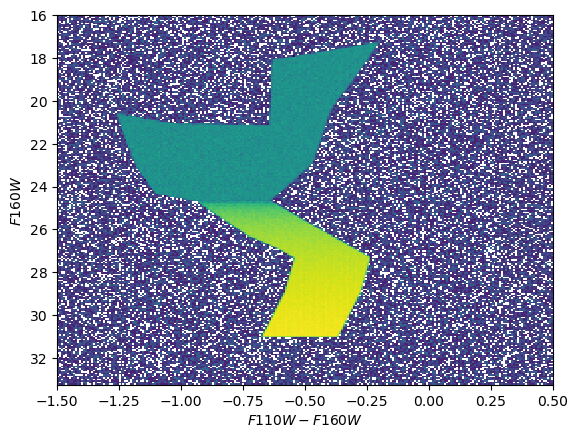

In [7]:
plt.hist2d(asdf['F110W_in'] - asdf['F160W_in'], asdf['F160W_in'],
          bins = 250, norm = LogNorm());

plt.gca().invert_yaxis()
plt.xlabel('$F110W - F160W$')
plt.ylabel('$F160W$')

Text(0, 0.5, '$F160W$')

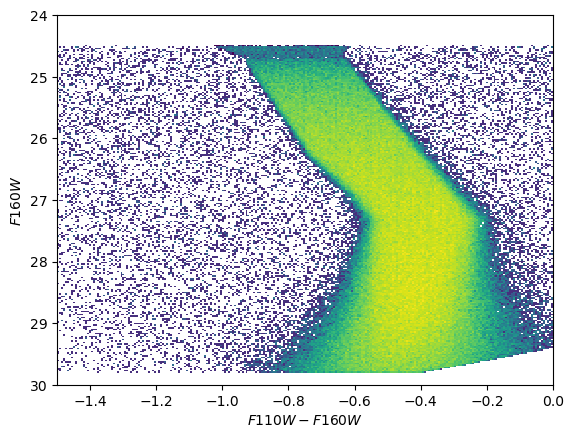

In [8]:
plt.hist2d(asdf['F110W_out'] - asdf['F160W_out'], asdf['F160W_out'],
          bins = 250, norm = LogNorm(),
          range = ((-1.5, 0), (24, 30)));

plt.gca().invert_yaxis()
plt.xlabel('$F110W - F160W$')
plt.ylabel('$F160W$')

### Load SFH Grid

In [9]:
with bz2.BZ2File('../../LMC_4Vedant/SFH_2d_frommarginals_metalbound.pbz2') as f:
    sfh_grid = pd.read_pickle(f)

### Load HST LMC Data

In [10]:
with bz2.BZ2File('../../LMC_4Vedant/catalog.pbz2') as f:
    lmc = pd.read_pickle(f)
lmc = pd.DataFrame(lmc)

lmc = lmc[lmc['dat_det']]
lmc

,dat_mag1,dat_mag2,dat_det
1,28.933,29.465,True
4,28.787,29.199,True
5,28.821,29.254,True
10,26.865,27.196,True
20,29.299,29.526,True
...,...,...,...
20647,27.965,28.353,True
20648,26.744,27.186,True
20649,28.683,29.091,True
20651,27.760,28.121,True


In [11]:
lmc['F110W'] = lmc['dat_mag1']
lmc['F160W'] = lmc['dat_mag2']

Text(0, 0.5, '$F160W$')

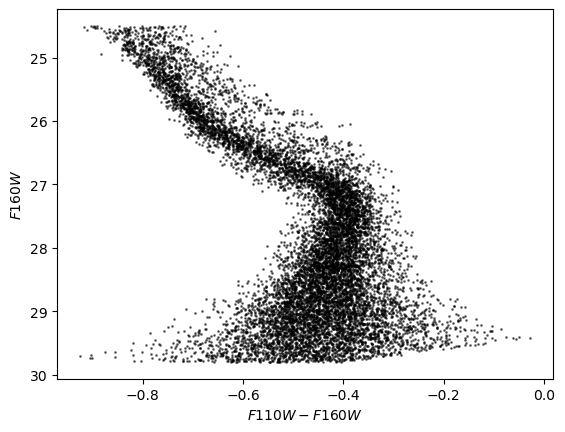

In [12]:
plt.scatter(lmc['F110W'] - lmc['F160W'], lmc['F160W'], s = 1, alpha = 0.5, color = 'k')

plt.gca().invert_yaxis()

plt.xlabel('$F110W - F160W$')
plt.ylabel('$F160W$')

In [13]:
shortbands = ['F160W', 'F110W']

### Setup starwave

In [14]:
print(np.min(isodf.index.get_level_values('age')))

print(np.max(isodf.index.get_level_values('age')))

0.5
15.815


In [15]:
print(sfh_grid['ages'].min())

0.0


In [16]:
print(sfh_grid['ages'].max())

13.4


In [17]:
starwave

<module 'starwave' from '/home/dkeyi/UMD/research/jwst_pid_3849/imf_fitting/starwave/nb/../starwave/starwave.py'>

In [18]:
sw = starwave.StarWave(isodf = isodf, asdf = asdf, imf_type = 'spl',
                      bands = shortbands, band_lambdas = [15369., 11534.],
                       sfh_type = 'grid', sfh_grid = sfh_grid)

interpolating 224 ages and 16 metallicities...


224it [00:08, 26.79it/s]


initalized starwave with ['F160W', 'F110W'] bands, spl IMF, and default priors
using Rv = 3.1


In [19]:
logint = 4.8
slope = -2.5

sw.params['dm'].set(value = 18.52, fixed = True, bounds = [18, 19])
sw.params['log_int'].set(value = logint, bounds = (logint - .5, logint + .25))
sw.params['bf'].set(value = 0.4, fixed = True)
sw.params['slope'].set(value = slope, bounds = (-4, -1))

sw.params['av'].set(value = 3.1 * 0.075, bounds = (0, 1), fixed = True)
#sw.params['av'].set(value = 0 * 0.075, bounds = (0, 1), fixed = True)

In [20]:
sw.params

SWParameters([('log_int',
               SWParameter([('name', 'log_int'),
                            ('value', 4.8),
                            ('bounds', (4.3, 5.05)),
                            ('distribution', 'uniform'),
                            ('dist_kwargs', None),
                            ('fixed', False)])),
              ('bf',
               SWParameter([('name', 'bf'),
                            ('value', 0.4),
                            ('bounds', [0, 1]),
                            ('distribution', 'uniform'),
                            ('dist_kwargs', None),
                            ('fixed', True)])),
              ('dm',
               SWParameter([('name', 'dm'),
                            ('value', 18.52),
                            ('bounds', [18, 19]),
                            ('distribution', 'uniform'),
                            ('dist_kwargs', None),
                            ('fixed', True)])),
              ('sig_dm',
               S

intNN warning: age out of bounds


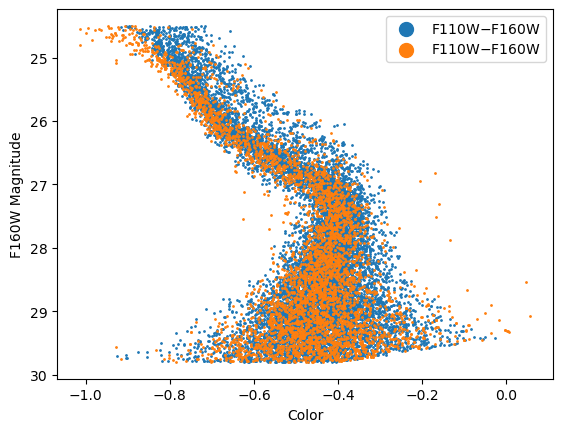

In [21]:
# Plot LMC and sampled CMD

lmc_mags = np.vstack((lmc[shortbands[0]], lmc[shortbands[1]])).T
#lmc_mags += exts # extinction correction
lmc_cmd = sw.make_cmd(lmc_mags)

params = torch.tensor([logint, -2.3])
eg_cmd = sw.sample_cmd(params, model = 'spl')[1]


# RESET 
#lmc_cmd = eg_cmd.copy()

starwave.plot_cmd(lmc_cmd, bands = shortbands)
starwave.plot_cmd(eg_cmd, bands = shortbands)

plt.gca().invert_yaxis()

In [22]:
eg_cmd

array([[29.09397104, -0.45313213],
       [28.19796125, -0.42258987],
       [27.41648317, -0.45064071],
       ...,
       [28.44161148, -0.41060262],
       [28.91640966, -0.32935614],
       [28.34640711, -0.36259138]])

In [23]:
lmc_cmd

array([[29.465, -0.532],
       [29.199, -0.412],
       [29.254, -0.433],
       ...,
       [29.091, -0.408],
       [28.121, -0.361],
       [29.474, -0.475]])

### Run Starwave

In [24]:
posteriors = sw.fit_cmd(lmc_cmd, cores = 1, n_sims = 100, n_rounds = 3, gamma = None, 
                       gamma_kw = dict(q = 0.68, NN = 5, fac = 1))

scaler initialized and mapping defined!
finding optimal kernel width...
setting gamma = 15229
verbose
----------
log_int
----------
Distribution:  uniform
Bounds:  (4.3, 5.05)
Value:  4.8
Fixed:  False
dist_kwargs:  None
----------
bf
----------
Distribution:  uniform
Bounds:  [0, 1]
Value:  0.4
Fixed:  True
dist_kwargs:  None
----------
dm
----------
Distribution:  uniform
Bounds:  [18, 19]
Value:  18.52
Fixed:  True
dist_kwargs:  None
----------
sig_dm
----------
Distribution:  uniform
Bounds:  [0, 0.5]
Value:  0.1
Fixed:  True
dist_kwargs:  None
----------
av
----------
Distribution:  uniform
Bounds:  (0, 1)
Value:  0.23249999999999998
Fixed:  True
dist_kwargs:  None
----------
slope
----------
Distribution:  uniform
Bounds:  (-4, -1)
Value:  -2.5
Fixed:  False
dist_kwargs:  None
Starting round 1 of neural inference...


  0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 199 epochs.Starting round 2 of neural inference...


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 56 epochs.Starting round 3 of neural inference...


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 60 epochs.

In [25]:
posteriors

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

In [26]:
import sbi

In [27]:
posterior = sw.posteriors[-1]

In [28]:
print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [29]:
posterior_samples = posterior.sample((1000000,), x = sw.obs)

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [30]:
from sbi.analysis import pairplot

/tmp/ipykernel_34440/3659686315.py:1: DeprecationWarning: you passed deprecated arguments **kwargs: ['fig_size'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  _ = pairplot(posterior_samples,


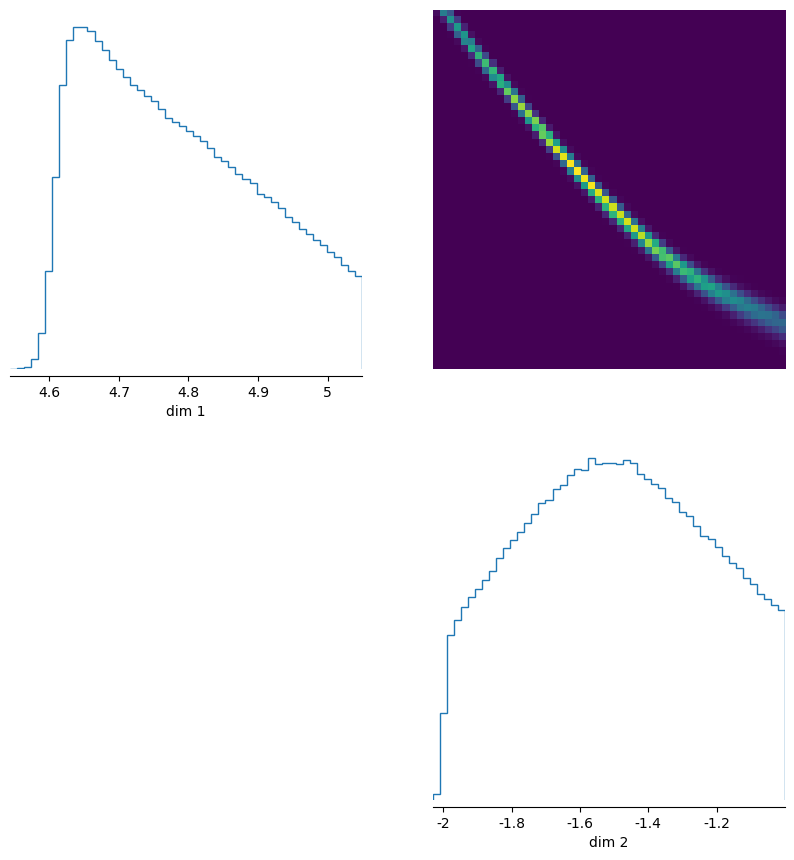

In [31]:
_ = pairplot(posterior_samples, 
                   fig_size=(10,10))

In [32]:
import corner

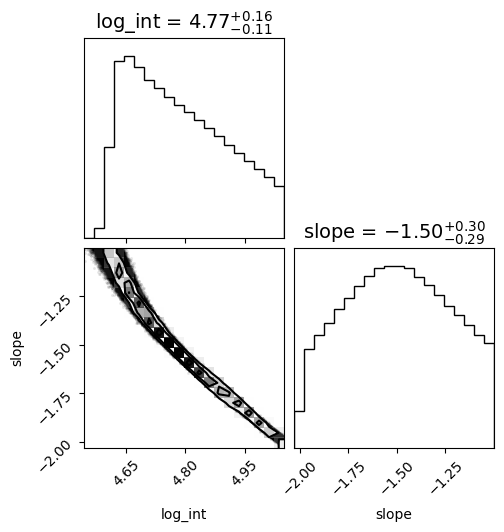

In [33]:
f = corner.corner(np.array(posterior_samples), show_titles = True, 
                  labels = list(sw.param_mapper.keys()), title_kwargs = dict(fontsize = 14))
                 #truths = [logint, slope])